### aim: Use GLODAPv2.2016b to create a set of DIC pseudoobservations for restart files. 

### date: 2023-05-08

Strategy

-#### aim: Make set of DIC pseudoobservations using a GLODAP ML product and various C_Anth (Anthropogenic C) estimates - for restarts and evaluation

Justification/Summary of approach:
the carbon content of the oceans changes through time, so to get the carbon content of the ocean at any one given year, we take the contemporary carbon content product, subtract an estimate of **contemporary** *anthropogenic* carbon content, and add back an estimate of *anthropogenic* carbon content for the target year.


Here's the method:
1) Get a current (year 2002) DIC content product (easy - just use GLODAPv2016b). 
    - In this case Keppler ML gridded product from here: https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0221526
    - This data contains observations made between 2004-2017. We will call it current for year 2011, I guess?
    - However it's only done for -64.5 lat to 64.5 lat, we need to make choices about what to do at the poles. 
2) Get an estimate of CAnth to date- actually to 2002:
    - Also from glodap
3) using a scaling relationship suggested by Corinne, find the CAnth for all years from 1880 to 2022
    - this relationship is scaled based on the Canth at 2002 gotten in step 2.
4) if you then have the product from 1) DIC_year2002, you can get DIC_yearX as:
    - DIC_year2002-CAnt_year2002 + CAnt_yearX
5) you then need to interpolate onto the model grid
6) you then need to convert umol/kg to umol/L (everything above is umol/kg), probably using some density 
    
    
Steps 1-4 will be done on the classic WOA grid - 33 depths * 180 lat * 360 lon (* 2022-1948 years)
Then we have to regrid to ORCA2 grid. 

In [120]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [121]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [122]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [123]:
glodapdir = '/gpfs/data/greenocean/observations/GLODAPv2.2016b_MappedClimatologies/'

tco2f = 'GLODAPv2.2016b.TCO2.nc'
cantf = 'GLODAPv2.2016b.Cant.nc'

tco2 = xr.open_dataset(f'{glodapdir}{tco2f}')
cant = xr.open_dataset(f'{glodapdir}{cantf}')

In [124]:
cant

<xarray.Dataset>
Dimensions:      (depth_surface: 33, lat: 180, lon: 360, snr: 1)
Coordinates:
  * lon          (lon) float64 20.5 21.5 22.5 23.5 ... 376.5 377.5 378.5 379.5
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: depth_surface, snr
Data variables:
    Cant         (depth_surface, lat, lon) float64 ...
    Cant_error   (depth_surface, lat, lon) float64 ...
    Input_mean   (depth_surface, lat, lon) float64 ...
    Input_std    (depth_surface, lat, lon) float64 ...
    Input_N      (depth_surface, lat, lon) float64 ...
    Cant_relerr  (depth_surface, lat, lon) float64 ...
    SnR          (snr) float64 ...
    CL           (snr) float64 ...
    Depth        (depth_surface) float64 ...
Attributes:
    Description:          1 X 1 global mapped field of anthropogenic carbon c...
    Created:              Created by Siv K. Lauvset on 12-May-2016 18:48:16
    Institution name:     University of Bergen
    Contact information:  siv.lauvset@uib.no; are.olsen@uib.no
    Citation:             Cite as: Lauvset, Siv K., Key, Robert M., Olsen, Ar...
    Comment:              Ttza2hhod0eend0s ai2eLlt  a iufucosivonilsr,neer gs...

## TCO2 (DIC) to 2002

Text(0.5, 1.0, 'DIC, GLODAPv2016b yr 2002\n umol/kg, 2000m')

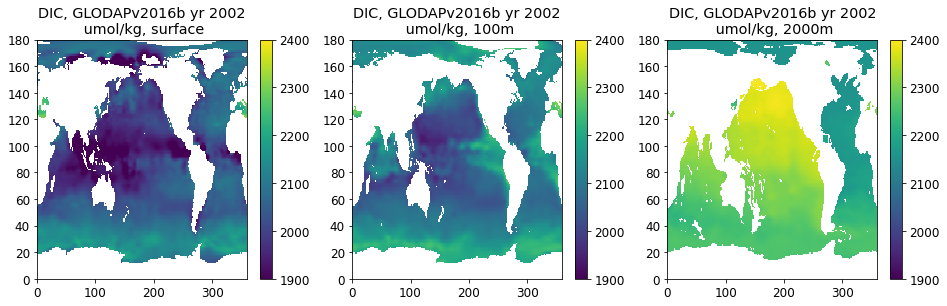

In [125]:
tmap = tco2.TCO2
tvmin = 1900
tvmax = 2400

fact = 0.4
fig, axs = plt.subplots(1,3, figsize=(40*fact, 11*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tw = axs[0].pcolormesh(tmap[0,:,:], vmin = tvmin, vmax = tvmax)
plt.colorbar(tw, ax = axs[0])
axs[0].set_title('DIC, GLODAPv2016b yr 2002\n umol/kg, surface')

tw = axs[1].pcolormesh(tmap[6,:,:], vmin = tvmin, vmax = tvmax)
plt.colorbar(tw, ax = axs[1])
axs[1].set_title('DIC, GLODAPv2016b yr 2002\n umol/kg, 100m')

tw = axs[2].pcolormesh(tmap[25,:,:], vmin = tvmin, vmax = tvmax)
plt.colorbar(tw, ax = axs[2])
axs[2].set_title('DIC, GLODAPv2016b yr 2002\n umol/kg, 2000m')

Text(0.5, 1.0, 'Anth DIC, GLODAPv2016b yr 2002\n umol/kg, 2000m')

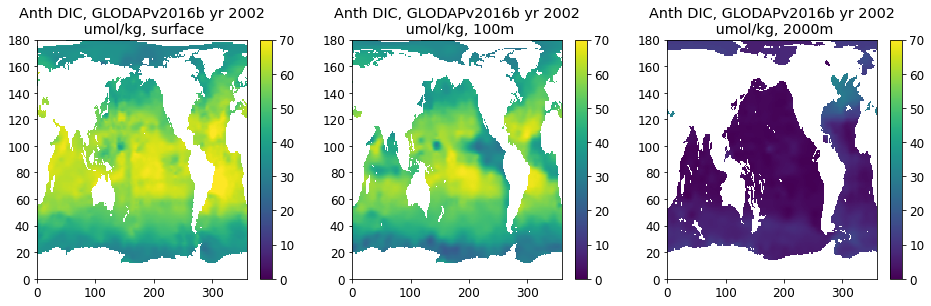

In [126]:
tmap = cant.Cant
tvmin = 0 
tvmax = 70

fact = 0.4
fig, axs = plt.subplots(1,3, figsize=(40*fact, 11*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tw = axs[0].pcolormesh(tmap[0,:,:], vmin = tvmin, vmax = tvmax)
plt.colorbar(tw, ax = axs[0])
axs[0].set_title('Anth DIC, GLODAPv2016b yr 2002\n umol/kg, surface')

tw = axs[1].pcolormesh(tmap[6,:,:], vmin = tvmin, vmax = tvmax)
plt.colorbar(tw, ax = axs[1])
axs[1].set_title('Anth DIC, GLODAPv2016b yr 2002\n umol/kg, 100m')

tw = axs[2].pcolormesh(tmap[25,:,:], vmin = tvmin, vmax = tvmax)
plt.colorbar(tw, ax = axs[2])
axs[2].set_title('Anth DIC, GLODAPv2016b yr 2002\n umol/kg, 2000m')

# Canth scaling, CLQ's notes

    DIC_yr = DIC_glodap - DICant*(1-alpha)
    alpha = (atmco2(glodap)-atmco2(t))/atmco2(glodap)
    
note putting atmospheric pco2 here: `/gpfs/data/greenocean/observations/GCB_atm_co2`
    
We have DICant for 2002
DICant for 2011 will be LARGER

Find DICant_yr:

DICant_yr = DICant_(2002) * (1-(atmco2(2002)-atmco2(yr))/atmco2(2002)


In [127]:
atmo_co2 = pd.read_csv('/gpfs/data/greenocean/observations/GCB_atm_co2/global_co2_merged.csv')

atmo_co2.columns

Index(['year', 'co2_ppm', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6'],
      dtype='object')

atm co2 (uatm) at 2002: 372.1458333333333
atm co2 (uatm) at 1700: 276.5941666666667


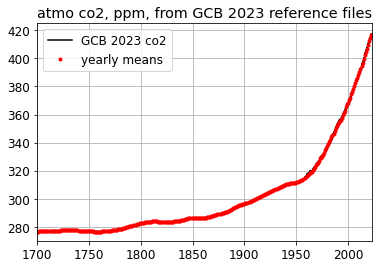

In [128]:

yr = atmo_co2['year'].values
co2atm = atmo_co2['co2_ppm'].values

yrmns = np.arange(1700,2023,1)
yrmn_co2 = np.arange(1700,2023,1)
yrmn_co2 = yrmn_co2.astype('float')

for i in range(1700,2023):
    yrmn_co2[i-1700] = np.nanmean(co2atm[(yr >= i) & (yr< i+1)])
    # print(yrmn_co2[i-1700])
    
plt.figure()
plt.plot(yr,co2atm, 'k-', label = 'GCB 2023 co2')
plt.plot(yrmns,yrmn_co2, 'r.', label = 'yearly means')
plt.legend()
plt.xlim([1700,2023])
plt.ylim([270,425])
plt.grid()
plt.title('atmo co2, ppm, from GCB 2023 reference files')
print(f'atm co2 (uatm) at 2002: {yrmn_co2[yrmns == 2002][0]}')
print(f'atm co2 (uatm) at 1700: {yrmn_co2[yrmns == 1700][0]}')

## The scaling factor

red (as written by corinne) = [change in anthropogenic co2 between year-of-interest and year-2007(reference)] / [anthro co2 at year-2007(reference)]

I think it is more accurate to scale as (change between the two atm co2 measuements) / (change between reference measurement and preindustrial) (Shown in black)

That way alpha just represents the proportion of the change in anthropogenic atmospheric co2 from 1800-2007, since we didn't start at 0. using black line alpha

In [129]:
yrmn_co2[yrmns == 1700]

array([276.59416667])

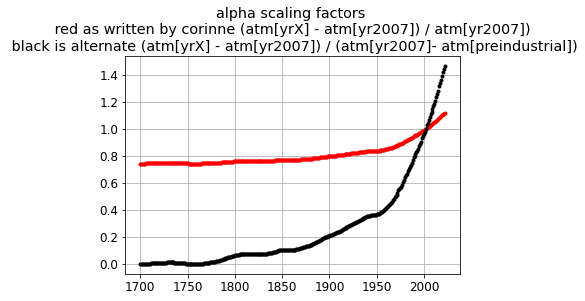

In [130]:
alpha = np.arange(1700,2023,1).astype('float')
alpha2 = np.arange(1700,2023,1).astype('float')

for i in range(1700,2023):
    alpha[i-1700] =  (1-(yrmn_co2[yrmns == 2002]-yrmn_co2[yrmns == i])/yrmn_co2[yrmns == 2002])
    alpha2[i-1700] =  (1-(yrmn_co2[yrmns == 2002]-yrmn_co2[yrmns == i])/(yrmn_co2[yrmns == 2002]-276.5941666666667))
plt.figure()
plt.plot(yrmns,alpha, 'r.', label = 'yearly means')
plt.plot(yrmns,alpha2, 'k.', label = 'yearly means')
plt.grid()
q = plt.title('alpha scaling factors \n red as written by corinne (atm[yrX] - atm[yr2007]) / atm[yr2007]) \n black is alternate (atm[yrX] - atm[yr2007]) / (atm[yr2007]- atm[preindustrial])')

In [131]:
cant

<xarray.Dataset>
Dimensions:      (depth_surface: 33, lat: 180, lon: 360, snr: 1)
Coordinates:
  * lon          (lon) float64 20.5 21.5 22.5 23.5 ... 376.5 377.5 378.5 379.5
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: depth_surface, snr
Data variables:
    Cant         (depth_surface, lat, lon) float64 ...
    Cant_error   (depth_surface, lat, lon) float64 ...
    Input_mean   (depth_surface, lat, lon) float64 ...
    Input_std    (depth_surface, lat, lon) float64 ...
    Input_N      (depth_surface, lat, lon) float64 ...
    Cant_relerr  (depth_surface, lat, lon) float64 ...
    SnR          (snr) float64 10.0
    CL           (snr) float64 7.0
    Depth        (depth_surface) float64 0.0 10.0 20.0 ... 4.5e+03 5e+03 5.5e+03
Attributes:
    Description:          1 X 1 global mapped field of anthropogenic carbon c...
    Created:              Created by Siv K. Lauvset on 12-May-2016 18:48:16
    Institution name:     University of Bergen
    Contact information:  siv.lauvset@uib.no; are.olsen@uib.no
    Citation:             Cite as: Lauvset, Siv K., Key, Robert M., Olsen, Ar...
    Comment:              Ttza2hhod0eend0s ai2eLlt  a iufucosivonilsr,neer gs...

In [132]:
horse = False
if horse:

    refyrs = np.arange(1700,2023,1).astype('float')
    long = cant['lon'].values
    lat = cant['lat'].values
    dep = cant['Depth'].values

    for i in range(0,len(refyrs)):
        ty = int(refyrs[i])
        talpha = alpha2[i]
        Anth_DIC = np.zeros([33,180,360])
        Anth_DIC= talpha * cant.Cant.values
        Anth_DIC[cant.Cant.values == 0] = np.nan
        print(f'{ty}, alpha = {talpha}, maxdic = {np.nanmax(Anth_DIC)}')
        # print(talpha)
        # print(np.nanmax(Anth_DIC))
        data_vars = {'Anth_DIC':(['depth', 'lat', 'lon'], Anth_DIC,
                                 {'units': 'µmol/kg',
                                  'long_name':'anthropogenic DIC'})           
                    }

        # define coordinates
        coords = {'depth': (['depth'], dep),\
                 'lat': (['lat'], lat),\
                 'lon': (['lon'], long)}

        # define global attributes
        attrs = {'made in':'Tuning/glodapBasedRestart.ipynb',
                }   

        ds = xr.Dataset(data_vars=data_vars,
                        coords=coords,
                        attrs=attrs)

        fn = f'./GLODAP_AnthDIC/AnthDIC_{ty}.nc'
        ds.to_netcdf(fn)

## quick check, visualize anthropogenic co2, make sure it makes something approaching sense

In [133]:
yr = 1800
w = xr.open_dataset(f'GLODAP_AnthDIC/AnthDIC_{yr}.nc')

print(np.nanmax(w.Anth_DIC.values))

# tw = plt.pcolormesh((w.Anth_DIC[0,:,:]))
# print(np.cant(w.Anth_DIC[0,:,:]))

4.533401475550954


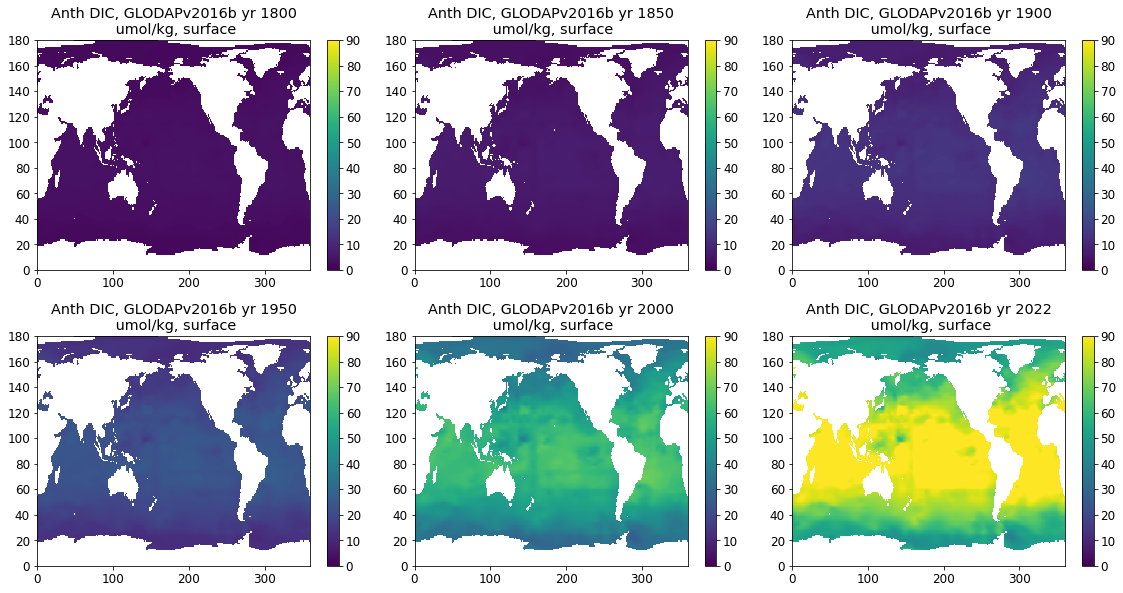

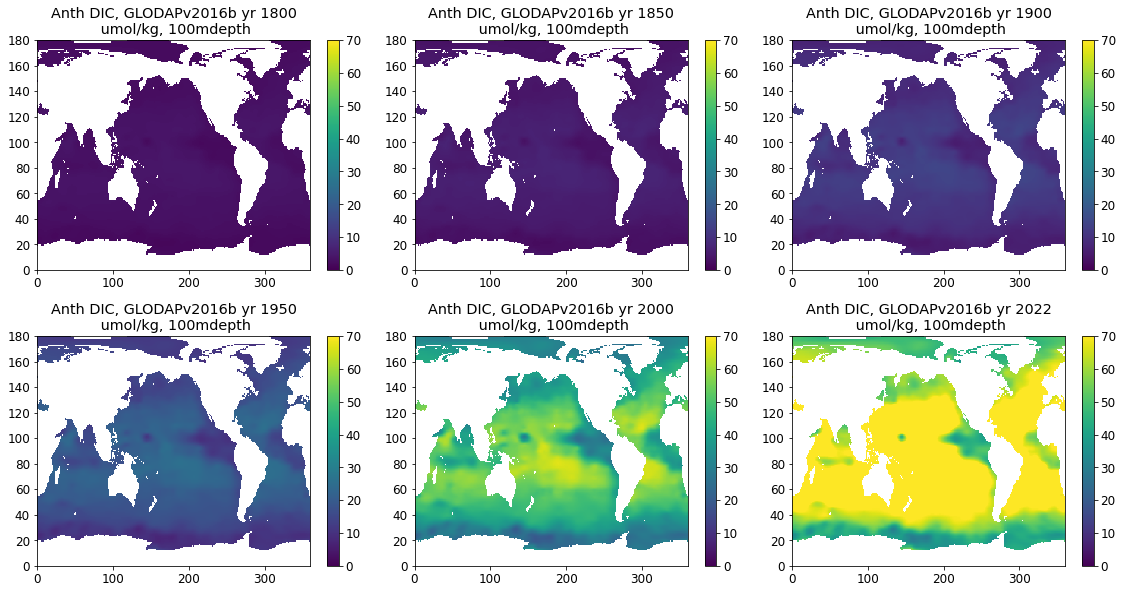

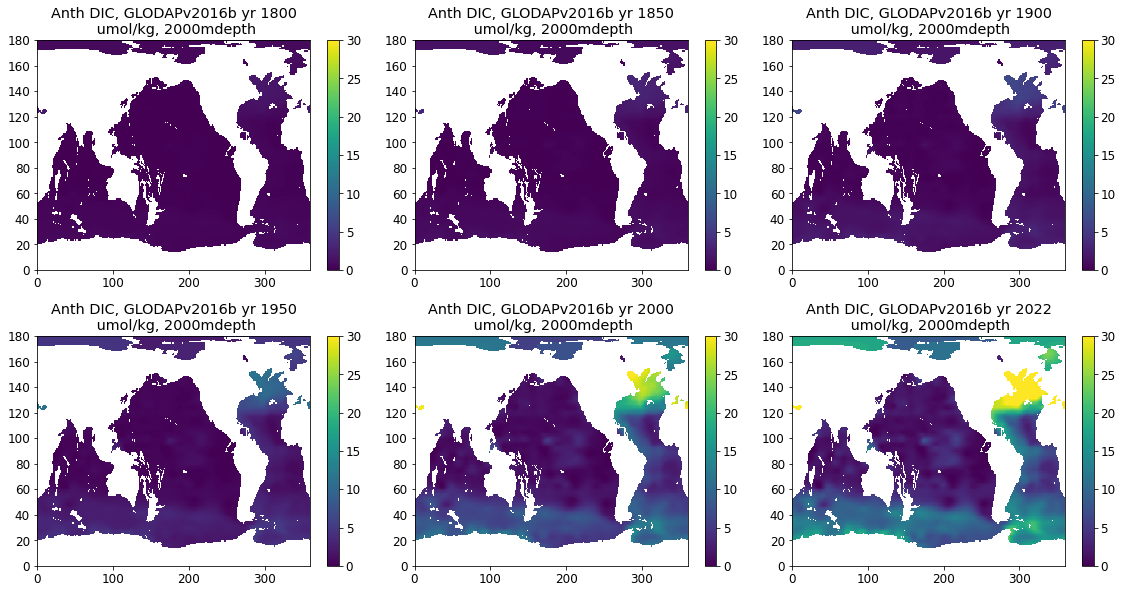

In [140]:

fact = 0.4
fig, axs = plt.subplots(2,3, figsize=(40*fact, 21*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tvmin = 0; tvmax = 90
yrs = [1800, 1850, 1900, 1950, 2000, 2022]

for i in range(0,6):
    
    w = xr.open_dataset(f'GLODAP_AnthDIC/AnthDIC_{yrs[i]}.nc')
    tw = axs[i].pcolormesh((w.Anth_DIC[0,:,:]), vmin = tvmin, vmax = tvmax)
    plt.colorbar(tw, ax = axs[i])
    axs[i].set_title(f'Anth DIC, GLODAPv2016b yr {yrs[i]}\n umol/kg, surface')

plt.tight_layout()

####

fact = 0.4
fig, axs = plt.subplots(2,3, figsize=(40*fact, 21*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tvmin = 0; tvmax = 70
yrs = [1800, 1850, 1900, 1950, 2000, 2022]

for i in range(0,6):
    
    w = xr.open_dataset(f'GLODAP_AnthDIC/AnthDIC_{yrs[i]}.nc')
    tw = axs[i].pcolormesh((w.Anth_DIC[6,:,:]), vmin = tvmin, vmax = tvmax)
    plt.colorbar(tw, ax = axs[i])
    axs[i].set_title(f'Anth DIC, GLODAPv2016b yr {yrs[i]}\n umol/kg, 100mdepth')

plt.tight_layout()

#####

fact = 0.4
fig, axs = plt.subplots(2,3, figsize=(40*fact, 21*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tvmin = 0; tvmax = 30
yrs = [1800, 1850, 1900, 1950, 2000, 2022]

for i in range(0,6):
    
    w = xr.open_dataset(f'GLODAP_AnthDIC/AnthDIC_{yrs[i]}.nc')
    tw = axs[i].pcolormesh((w.Anth_DIC[25,:,:]), vmin = tvmin, vmax = tvmax)
    plt.colorbar(tw, ax = axs[i])
    axs[i].set_title(f'Anth DIC, GLODAPv2016b yr {yrs[i]}\n umol/kg, 2000mdepth')

plt.tight_layout()

#### get preindustrial C

In [146]:
horse = False

if horse:
    ### get preindustrial tmap = tco2.TCO2
    AnthDIC_2002 = xr.open_dataset('./GLODAP_AnthDIC/AnthDIC_2002.nc')
    A2002vals = AnthDIC_2002['Anth_DIC'].values
    A2002vals[A2002vals == 0] = np.nan
    DIC_fg = tco2.TCO2.values
    DIC_PI = np.zeros_like(tco2.TCO2.values)
    DIC_fg[DIC_fg == 0] = np.nan
    DIC_PI = DIC_fg - A2002vals

    long = cant['lon'].values
    lat = cant['lat'].values
    dep = cant['Depth'].values


    data_vars = {'Reconstructed_DIC':(['depth', 'lat', 'lon'], DIC_PI,
                             {'units': 'µmol/kg',
                              'long_name':'reconstructed DIC'})           
                }

    # define coordinates
    coords = {
             'depth': (['depth'], dep),\
             'lat': (['lat'], lat),\
             'lon': (['lon'], long)}

    # define global attributes
    attrs = {'made in':'Tuning/glodapBasedRestart.ipynb',
            }   

    ds = xr.Dataset(data_vars=data_vars,
                    coords=coords,
                    attrs=attrs)

    fn = f'./GLODAP_AnthDIC/EstimatedDIC_PI_1700.nc'
    ds.to_netcdf(fn)

#### get C for all years, 1700 to 2017


In [150]:
horse = False
if horse:
    PI_DIC = xr.open_dataset('./GLODAP_AnthDIC/EstimatedDIC_PI_1700.nc')
    PI_DICvals = PI_DIC['Reconstructed_DIC'].values

    for y in range(1700,2023):
        #print(y)
        anth_DIC = xr.open_dataset(f'./GLODAP_AnthDIC/AnthDIC_{y}.nc')
        anth_DICvals = anth_DIC['Anth_DIC'].values
        #print(np.nanmax(anth_DICvals))
        DIC_thisyear = np.zeros_like(PI_DICvals)

        DIC_thisyear = PI_DICvals  + anth_DICvals

        data_vars = {'Reconstructed_DIC':(['depth', 'lat', 'lon'], DIC_thisyear,
                                 {'units': 'µmol/kg',
                                  'long_name':'reconstructed DIC'})           
                    }
        
        print(f'{y}, DIC is {np.nanmin(DIC_thisyear)}- {np.nanmax(DIC_thisyear)}')

        # define coordinates
        coords = {
                 'depth': (['depth'], dep),\
                 'lat': (['lat'], lat),\
                 'lon': (['lon'], long)}

        # define global attributes
        attrs = {'made in':'Tuning/glodapBasedRestart.ipynb',
                }   

        ds = xr.Dataset(data_vars=data_vars,
                        coords=coords,
                        attrs=attrs)

        fn = f'./GLODAP_AnthDIC/EstimatedDIC_{y}.nc'
        print(fn)
        ds.to_netcdf(fn)

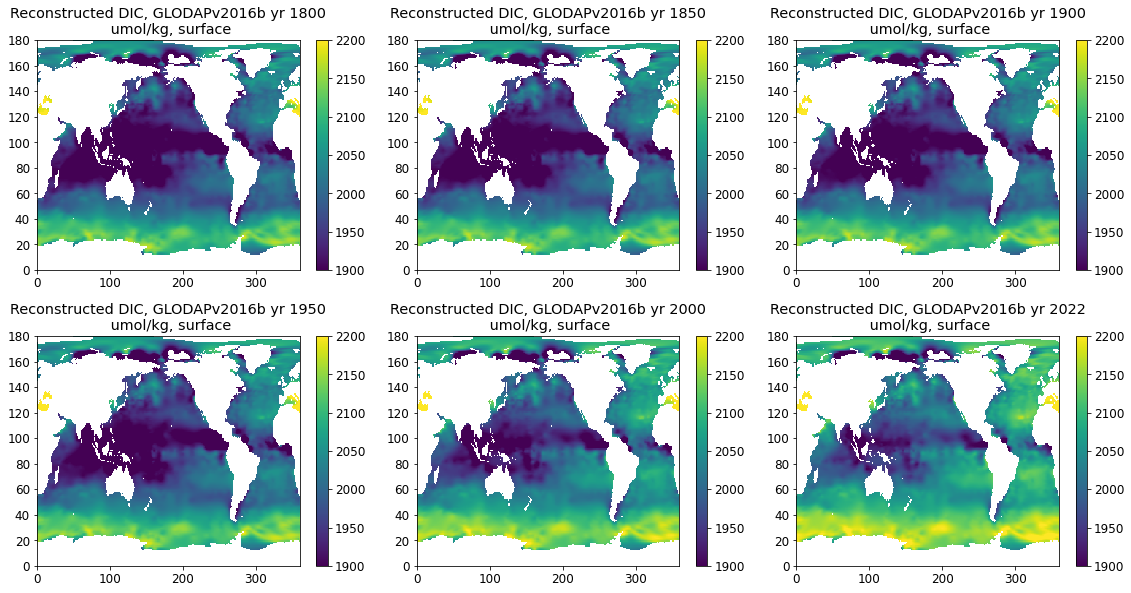

In [154]:

fact = 0.4
fig, axs = plt.subplots(2,3, figsize=(40*fact, 21*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tvmin = 1900; tvmax = 2200
yrs = [1800, 1850, 1900, 1950, 2000, 2022]

for i in range(0,6):
    
    w = xr.open_dataset(f'GLODAP_AnthDIC/EstimatedDIC_{yrs[i]}.nc')
    tw = axs[i].pcolormesh((w.Reconstructed_DIC[0,:,:]), vmin = tvmin, vmax = tvmax)
    plt.colorbar(tw, ax = axs[i])
    axs[i].set_title(f'Reconstructed DIC, GLODAPv2016b yr {yrs[i]}\n umol/kg, surface')

plt.tight_layout()


### sanity check

    take glodap year 2002 = G02
    get preindustrial = GPI 
    and subtract to (G02-GPI) and see if you get Canth

In [161]:
G02 = tco2.TCO2.values
cant_orig = cant.Cant.values
w = xr.open_dataset(f'GLODAP_AnthDIC/EstimatedDIC_2002.nc')
G02_rec = w.Reconstructed_DIC.values


G02diff = G02-G02_rec

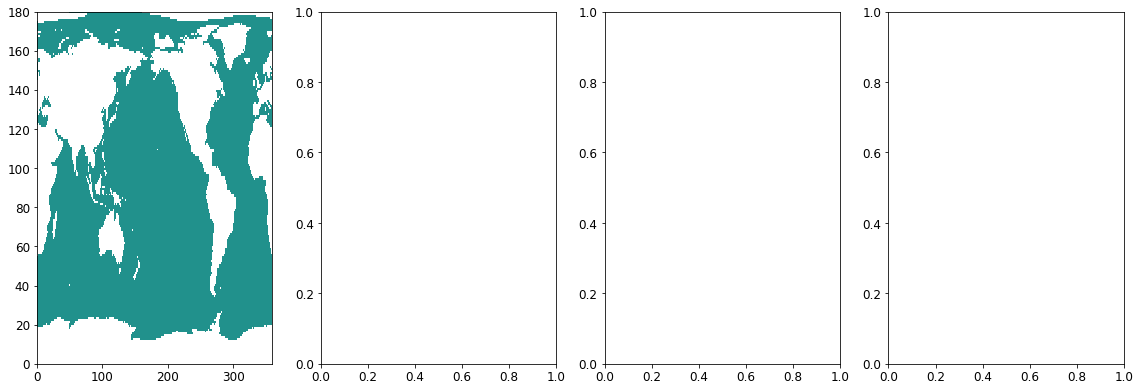

In [164]:
fact = 0.4
fig, axs = plt.subplots(1,2, figsize=(40*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


tw = axs[0].pcolormesh(G02diff[0,:,:], vmin = -10, vmax = 10)
axs[0].set_title('reconstructed year 2002 - 

plt.tight_layout()